Cell 1 (imports + DB connection)

In [1]:
from pathlib import Path

import sqlite3

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

conn = sqlite3.connect(db_path)

Cell 2 (return distribution)

- This is key.
- Using daily revenue changes as our return proxy.
- This column is the empirical return distribution.

In [2]:
query = """

SELECT

     DATE(order_ts) AS day,

     SUM(net_revenue) AS revenue

FROM orders

GROUP BY day

ORDER BY day;

"""

daily = pd.read_sql_query(query, conn)

daily["day"] = pd.to_datetime(daily["day"])

daily["daily_change"] = daily["revenue"].diff()

daily.dropna(inplace=True)

daily.head()

,day,revenue,daily_change
1,2024-01-02,1456.57,34.35
2,2024-01-03,1459.21,2.64
3,2024-01-04,2009.31,550.10
4,2024-01-05,1429.87,-579.44
5,2024-01-06,1428.31,-1.56


Cell 3 (estimate distribution parameters)

- mu --> expected value change.
- sigma --> daily volatility.
- This is exactly how return models start.

In [3]:
mu = daily["daily_change"].mean()

sigma = daily["daily_change"].std()

mu, sigma

(np.float64(-0.6671604938271644), np.float64(873.4503341878619))

Cell 4 (monte carlo simulation)

 - Simulate many possible futures
 - Each row = one possible future.
 - Each column = one day.

In [4]:
n_days = 60               # forecast horizon

n_sims = 1000             # number of simulated paths

simulated_paths = np.random.normal(

    loc=mu,

    scale=sigma,

    size=(n_sims, n_days)

)

simulated_paths.shape

(1000, 60)

Cell 5 (convert to culmulative outcomes)
 
 - Now each path shows how performance evolves over time.

In [6]:
culmulative_paths = simulated_paths.cumsum(axis=1)

Cell 6 (visualize uncertainty)

 - This plot is everything.
 - Wide fan --> high uncertainty.
 - Narrow fan --> stable process.

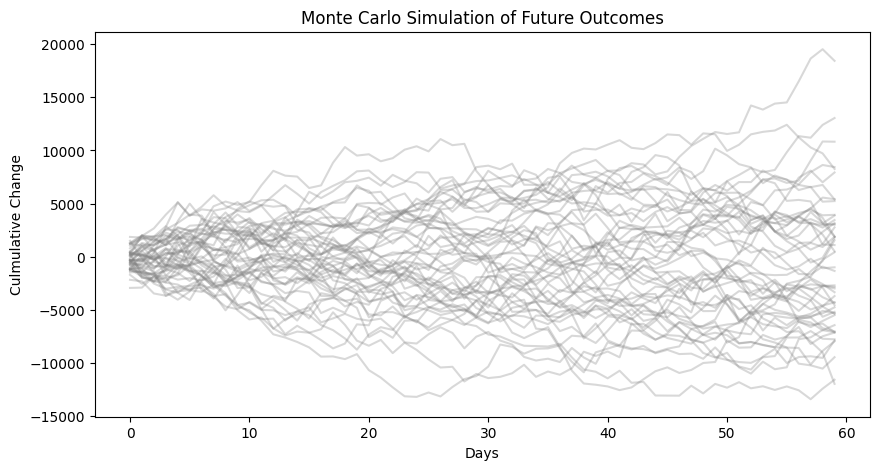

In [7]:
plt.figure(figsize=(10,5))

for i in range(50): # plot only 50 paths for clarity

    plt.plot(culmulative_paths[i], color="gray", alpha=0.3)

plt.title("Monte Carlo Simulation of Future Outcomes")

plt.xlabel("Days")

plt.ylabel("Culmulative Change")

plt.show()

Cell 7 (quantify risk "percentiles")

  - 5th percentile --> bad case scenario.
  - 50th --> median expectation.
  - 95th --> upside potential.
  - This is risk aware decision making.

In [8]:
final_outcomes = culmulative_paths[:, -1]

np.percentile(final_outcomes, [5, 25, 50, 75, 95])

array([-10664.54118033,  -4733.64390167,   -157.91244141,   3940.73377385,
        12134.69616999])

## Day 6 - Monte Carlo Insights

   - Monte Carlo simulation generates a distribution of possible future outcomes rather than a single forecast.
   - Expected value alone is insufficient; outcome dispersion and tail risk matter.
   - Percentile based analysis provides a clearer view of downside and upside risk.
   - Simulation based thinking helps evaluate robustness under uncertainty.

   Monte Carlo methods are central to quantitative finance and risk management.

